# Informes de la comunidad de Madrid

Actualizado diariamente, este documento se [visualiza mejor aquí](https://nbviewer.jupyter.org/github/jaimevalero/COVID-19/blob/master/jupyter/Madrid_Pain_Graphs.ipynb).

Datos de la situación de la infección por coronavirus en la Comunidad de Madrid.

Nos descargamos los datos, agrupamos, y calculamos :

- Gráfico de seguimiento.


- Muertes medias diarias, últimos 7 días.


- Muertes medias diarias desde que la comunidad de Madrid publica datos.



In [7]:
# Miramos si hay nuevos datos a descargar.

!# cd ../data/; FILELIST=" 200509 200508 200507 200506 200505 200504 200503 200502 200501 200430 200429 200428 200427 200426 200425 200424 200423 200422 200510 200511 200512 200513 200514 200515 200516 200517 200518 200519 200520 200521 200522 200523 200524 200525 200526 200527 200528 200529 200530 200609 200608 200607 200606 200605 200604 200603 200602 200601 200610 200611 200612 200613 200614 200615 200616 200617 200618 200619 200620 200621 200622 200623 200624 200625 200626 200627 200628 200629 200630 " ; for fecha in `echo $FILELIST`  ; do  FILE=${fecha}_cam_covid19.pdf ;  [ ! -f ../data/${FILE} ] && echo $FILE:::::    && wget https://www.comunidad.madrid/sites/default/files/doc/sanidad/$FILE 1>/dev/null  2>/dev/null && ls -altr $FILE ; done 

# Miramos solo hoy y los ultimos diez dias
! cd ../data/; FILELIST=`seq -w 0 2 | while read i ; do date +%y%m%d -d "$i day ago" ; done` ; for fecha in `echo $FILELIST`  ; do  FILE=${fecha}_cam_covid19.pdf ;  [ ! -f ../data/${FILE} ] && echo $FILE:::::    && wget https://www.comunidad.madrid/sites/default/files/aud/sanidad/$FILE  1>/dev/null  2>/dev/null && ls -altr $FILE ; done 
! cd ../data/; FILELIST=`seq -w 0 2 | while read i ; do date +%y%m%d -d "$i day ago" ; done` ; for fecha in `echo $FILELIST`  ; do  FILE=${fecha}_cam_covid19.pdf ;  [ ! -f ../data/${FILE} ] && echo $FILE:::::    && wget https://www.comunidad.madrid/sites/default/files/doc/sanidad/$FILE  1>/dev/null  2>/dev/null && ls -altr $FILE ; done 
! cd ../data/; FILELIST=`seq -w 0 2 | while read i ; do date +%y%m%d -d "$i day ago" ; done` ; for fecha in `echo $FILELIST`  ; do  FILE=${fecha}cam_covid19.pdf ;  [ ! -f ../data/${FILE} ] && echo $FILE:::::    && wget https://www.comunidad.madrid/sites/default/files/doc/sanidad/$FILE   1>/dev/null  2>/dev/null && ls -altr $FILE ; done 
! cd ../data/; FILELIST=`seq -w 0 2 | while read i ; do date +%Y%m%d -d "$i day ago" ; done` ; for fecha in `echo $FILELIST`  ; do  FILE=${fecha}_cam_covid19.pdf ;  [ ! -f ../data/${FILE} ] && echo $FILE:::::    && wget https://www.comunidad.madrid/sites/default/files/doc/sanidad/$FILE  1>/dev/null  2>/dev/null && ls -altr $FILE ; done 
! cd ../data/; FILELIST=`seq -w 0 2 | while read i ; do date +%y%m%d -d "$i day ago" ; done` ; for fecha in `echo $FILELIST`  ; do  FILE=${fecha}_cam_covid19.pdf ;  [ ! -f ../data/${FILE} ] && echo $FILE:::::    && wget https://www.comunidad.madrid/sites/default/files/$FILE 1>/dev/null  1>/dev/null  2>/dev/null && ls -altr $FILE ; done 
! cd ../data/; FILELIST=`seq -w 0 2 | while read i ; do date +%-d.%-m.%Y -d "$i day ago" ; done` ; for fecha in `echo $FILELIST`  ; do  FILE=${fecha}_2.pdf ;  [ ! -f ../data/${FILE} ] && echo $FILE:::::    && wget https://www.comunidad.madrid/sites/default/files/doc/sanidad/$FILE        1>/dev/null  2>/dev/null && ls -altr $FILE ; done 

                        #200902_cam_covid19.pdf

201203_cam_covid19.pdf:::::
201203_cam_covid19.pdf:::::
201203cam_covid19.pdf:::::
201202cam_covid19.pdf:::::
201201cam_covid19.pdf:::::
20201203_cam_covid19.pdf:::::
20201202_cam_covid19.pdf:::::
20201201_cam_covid19.pdf:::::
201203_cam_covid19.pdf:::::
2.12.2020_2.pdf:::::
1.12.2020_2.pdf:::::


In [24]:
from tabula import read_pdf
from IPython.display import display, HTML
import os 
import pandas as pd
import glob 
import re 
from tqdm.notebook import tqdm
import warnings
import os.path
#import datetime
warnings.filterwarnings('ignore')


os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.8.0-openjdk-1.8.0.141-1.b16.el7_3.x86_64/jre"

# Auxiliary functions
from datetime import datetime, date, time, timedelta

df_cache = pd.read_csv("/root/kaggle/covid19-madrid/madrid_results.csv")

def query_cache(fecha):
    """ Query cache file to avoid parse pdf
    return empty dataframe is not found"""
    try :        
        date_formatted = datetime.strptime(fecha, '%y%m%d').strftime('%Y-%m-%d')
        df = df_cache.query( 'Fecha==@date_formatted')
    except:
        print("Cache miss:" , fecha)
        return pd.DataFrame()
    
    try:
        df['Fecha'] =  pd.to_datetime(fecha, format='%y%m%d')
    except :
        df['Fecha'] =  pd.to_datetime(fecha, format='%Y%m%d')
    df.set_index('Fecha', inplace=True, drop=True)
    return df 

""" Rellenar dias vacios con interpolacion"""
def interpolate_dataframe(df,freq):
    if freq == 'H':
        rng = pd.date_range(df.index.min(), df.index.max() + pd.Timedelta(23, 'H'), freq='H')
    elif freq == 'D' :  
        rng = pd.date_range(
                        datetime.strptime(str(df.index.min())[:10]+' 00:00:00', "%Y-%m-%d %H:%M:%S") ,
                        datetime.strptime(str(df.index.max())[:10]+' 00:00:00', "%Y-%m-%d %H:%M:%S"), 
                        freq='D')
        df.index = pd.to_datetime(df.index)  
    df2 = df.reindex(rng)
    df = df2
    for column in df.columns :
        s = pd.Series(df[column])
        s.interpolate(method="quadratic", inplace =True)
        df[column] = pd.DataFrame([s]).T
    return df

def get_daily_date_new_format(fecha,filename): 
    
    file_path = '../data/'+fecha+'_cam_covid19.pdf'
    if not os.path.isfile(file_path):
        file_path = '../data/'+fecha+'cam_covid19.pdf'
    if not os.path.isfile(file_path):
        file_path = filename
        
    #print("Analizando:" + file_path)
    df_pdf =  read_pdf(file_path,area=(000, 600, 400, 800) , pages='1')
      

    df = df_pdf[0]
    df = df['Unnamed: 0'].astype(str).str.replace(r".", '').replace("(", ' ')
    df = df.T
    df.columns = df.iloc[0]
    df = df.iloc[1:]

    #print("2 get_daily_date_new_format")

    df = pd.DataFrame(data=df)
    df    

    dict = {}
    try:
        df2_pdf =  read_pdf(file_path,area=(300, 100, 800, 400) , pages='1')
        dict['PACIENTES UCI DIA']       = df2_pdf[0].loc[3:3].values[0][1].replace(".",'')
        dict['PACIENTES UCI ACUMULADOS']= df2_pdf[0].loc[6:6].values[0][1].replace(".",'')
    except Exception as e:
        print(f"{fecha} mal parseada: {e}")
        
    dict['HOSPITALES'] = df[df['Unnamed: 0'].str.contains('Hospitales')].iloc[0]['Unnamed: 0'].split(' ')[0]
    dict['DOMICILIOS'] = df[df['Unnamed: 0'].str.contains('Domicilios')].iloc[0]['Unnamed: 0'].split(' ')[0]
    dict['CENTROS SOCIOSANITARIOS'] = df[df['Unnamed: 0'].str.contains('Centros')].iloc[0]['Unnamed: 0'].split(' ')[0]
    dict['OTROS LUGARES'] = df[df['Unnamed: 0'].str.contains('otros')].iloc[0]['Unnamed: 0'].split(' ')[0]
    #print("3 get_daily_date_new_format")

    cadena_a_parsear = df[df['Unnamed: 0'].str.contains('otal')].iloc[0]['Unnamed: 0']

    dict['FALLECIDOS TOTALES'] = re.search(r'(\d+)', cadena_a_parsear)[0]

    #print("4 get_daily_date_new_format")
    df = pd.DataFrame.from_dict(dict, orient='index').T
    #print("4.5 get_daily_date_new_format")
    
    try:
        df['Fecha'] =  pd.to_datetime(fecha, format='%y%m%d')
    except :
        df['Fecha'] =  pd.to_datetime(fecha, format='%Y%m%d')
    
    #print("5 get_daily_date_new_format")

    df.set_index('Fecha', inplace=True, drop=True)
    #print(df)
    return df


def get_daily_data(fecha,filename):
    #print(f"""get_daily_data: {fecha}""")
    #print(f"""../data/{fecha}_cam_covid19.pdf""")

    if fecha > '200512' : 
        return get_daily_date_new_format(fecha,filename)
    
    col2str = {'dtype': str}
    kwargs = {'output_format': 'dataframe',
              'pandas_options': col2str,
              'stream': True}

    df_pdf =  read_pdf('../data/'+fecha+'_cam_covid19.pdf',pages='1',multiple_tables = True,**kwargs)

    
    df = df_pdf[0]

    df = df[df['Unnamed: 0'].notna()]
    df = df[(df['Unnamed: 0']=='HOSPITALES') | (df['Unnamed: 0'] == 'DOMICILIOS') | (df['Unnamed: 0'] == 'CENTROS SOCIOSANITARIOS') | (df['Unnamed: 0'] == 'OTROS LUGARES') | (df['Unnamed: 0'] == 'FALLECIDOS TOTALES')]
    df = df[['Unnamed: 0','Unnamed: 2']]
    df['Unnamed: 2'] = df['Unnamed: 2'].astype(str).str.replace(r".", '')
    df = df.T
    df.columns = df.iloc[0]
    df = df.iloc[1:]

    df['Fecha'] =  pd.to_datetime(fecha, format='%y%m%d')
    df = df.rename_axis(None)

    df.set_index('Fecha', inplace=True, drop=True)
    df.index
    df.dropna()
    #df = df.T
    return df

def get_all_data( ): 
    #BLACKLIST = ["200429","200422"]
    #BLACKLIST = ["200514",]
    BLACKLIST = []
    df = pd.DataFrame()
    list_df = []
 
    #pdf_list= (glob.glob('../data/*_covid19.pdf'), 
    #                key=os.path.getmtime,
    #                 reverse=True )
    pdf_list= set(glob.glob('../data/*202*pdf') + glob.glob('../data/*cam_covid19.pdf'))
        
        
    for pdf_file in tqdm(pdf_list, 
                         desc="Procesando pdfs diarios"):   
        # extract fecha from username , eg : ../data/2200422_cam_covid19.pdf
         
        format_point_occurences = pdf_file.split('/')[2].split('_')[0].count(".")
        # Hack to fix filename inconsistences on remote server
        if format_point_occurences == 2 :
            day = pdf_file.split('/')[2].split('_')[0].split('.')[0].zfill(2)
            month = pdf_file.split('/')[2].split('_')[0].split('.')[1].zfill(2)
            year = pdf_file.split('/')[2].split('_')[0].split('.')[2][-2:]
            fecha = year+month+day
        else :
            fecha = pdf_file.split('/')[2].split('_')[0].replace('cam_','').replace('_cam_','').replace('cam','')
        if fecha not in BLACKLIST:
            # query cache, otherwise parse pdf
            df = query_cache(fecha) 
            if df.empty:
                df = get_daily_data(fecha,pdf_file) 
        list_df.append(df)

    df = pd.concat(list_df)
    df = df.fillna(0)
    df = df.astype(int)
    df = df.drop_duplicates()

    df = df.sort_values(by=['Fecha'], ascending=True)

    df['HOSPITALES hoy'] = df['HOSPITALES'] - df['HOSPITALES'].shift(1)
    df['CENTROS SOCIOSANITARIOS hoy'] = df['CENTROS SOCIOSANITARIOS'] - df['CENTROS SOCIOSANITARIOS'].shift(1)
    df['FALLECIDOS TOTALES hoy'] = df['FALLECIDOS TOTALES'] - df['FALLECIDOS TOTALES'].shift(1)

    df = df.sort_values(by=['Fecha'], ascending=False)

    return df 

total =  get_all_data()

total.to_csv('/root/kaggle/covid19-madrid/madrid_results.csv')
total

200515 mal parseada: index 1 is out of bounds for axis 0 with size 1
Cache miss: 20200814
200513 mal parseada: index 1 is out of bounds for axis 0 with size 1
200519 mal parseada: index 1 is out of bounds for axis 0 with size 1
200516 mal parseada: index 1 is out of bounds for axis 0 with size 1



,CENTROS SOCIOSANITARIOS,CENTROS SOCIOSANITARIOS hoy,DOMICILIOS,FALLECIDOS TOTALES,FALLECIDOS TOTALES hoy,HOSPITALES,HOSPITALES hoy,OTROS LUGARES,PACIENTES UCI ACUMULADOS,PACIENTES UCI DIA
Fecha,,,,,,,,,,
2020-12-03,4954,0.0,1146,18957,0.0,12827,0.0,30,6572,311
2020-12-02,4954,2.0,1146,18957,78.0,12827,72.0,30,6555,318
2020-12-01,4952,0.0,1142,18879,0.0,12755,0.0,30,6540,340
2020-11-30,4952,0.0,1142,18879,22.0,12755,21.0,30,6517,343
2020-11-29,4952,0.0,1141,18857,0.0,12734,0.0,30,6507,341
...,...,...,...,...,...,...,...,...,...,...
2020-04-26,4236,66.0,798,12855,243.0,7800,167.0,21,0,0
2020-04-25,4170,102.0,788,12612,360.0,7633,245.0,21,0,0
2020-04-24,4068,72.0,775,12252,196.0,7388,117.0,21,0,0


In [19]:
#import datetime
#datetime.datetime.strptime("2013-1-25", '%Y-%m-%d').strftime('%m/%d/%y')
    

'01/25/13'

In [13]:
total
df = total
df = df.fillna(0)
df = df.astype(int)
df

,CENTROS SOCIOSANITARIOS,DOMICILIOS,FALLECIDOS TOTALES,HOSPITALES,OTROS LUGARES,PACIENTES UCI ACUMULADOS,PACIENTES UCI DIA,HOSPITALES hoy,CENTROS SOCIOSANITARIOS hoy,FALLECIDOS TOTALES hoy
Fecha,,,,,,,,,,
2020-12-03,4954,1146,18957,12827,30,6572,311,0,0,0
2020-12-02,4954,1146,18957,12827,30,6555,318,72,2,78
2020-12-01,4952,1142,18879,12755,30,6540,340,0,0,0
2020-11-30,4952,1142,18879,12755,30,6517,343,21,0,22
2020-11-29,4952,1141,18857,12734,30,6507,341,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2020-04-26,4236,798,12855,7800,21,0,0,167,66,243
2020-04-25,4170,788,12612,7633,21,0,0,245,102,360
2020-04-24,4068,775,12252,7388,21,0,0,117,72,196


In [5]:
total 
VENTANA_MEDIA_MOVIL=7
df = interpolate_dataframe(total,'D')
df.index.name = 'Fecha'
df = df.sort_values(by=['Fecha'], ascending=True)
df['HOSPITALES hoy'] = df['HOSPITALES'] - df['HOSPITALES'].shift(1)
df['CENTROS SOCIOSANITARIOS hoy'] = df['CENTROS SOCIOSANITARIOS'] - df['CENTROS SOCIOSANITARIOS'].shift(1)
df['FALLECIDOS TOTALES hoy'] = df['FALLECIDOS TOTALES'] - df['FALLECIDOS TOTALES'].shift(1)


df['MA CENTROS SOCIOSANITARIOS hoy'] = df['CENTROS SOCIOSANITARIOS hoy'].rolling(window=VENTANA_MEDIA_MOVIL).mean()
df['MA HOSPITALES hoy'] = df['HOSPITALES hoy'].rolling(window=VENTANA_MEDIA_MOVIL).mean()
df['MA FALLECIDOS TOTALES hoy'] = df['FALLECIDOS TOTALES hoy'].rolling(window=VENTANA_MEDIA_MOVIL).mean()

df = df.sort_index(ascending=False)
df_master = df.copy()



In [6]:
total.head()

,CENTROS SOCIOSANITARIOS,DOMICILIOS,FALLECIDOS TOTALES,HOSPITALES,OTROS LUGARES,PACIENTES UCI ACUMULADOS,PACIENTES UCI DIA,HOSPITALES hoy,CENTROS SOCIOSANITARIOS hoy,FALLECIDOS TOTALES hoy
Fecha,,,,,,,,,,
2020-12-02,4954,1146,18957,12827,30,6555,318,72.0,2.0,78.0
2020-12-01,4952,1142,18879,12755,30,6540,340,0.0,0.0,0.0
2020-11-30,4952,1142,18879,12755,30,6517,343,21.0,0.0,22.0
2020-11-29,4952,1141,18857,12734,30,6507,341,0.0,0.0,0.0
2020-11-28,4952,1141,18857,12734,30,6496,339,0.0,0.0,0.0


In [7]:
# Hacemos lo contrario
# En lugar de sacar el nº de muertos dado el nº de infectados, como lo primero lo sabemos (en madrid), sacamos lo segundo y extrapolamos al conjunto de españa
df = df_master

R0_estimada = df['FALLECIDOS TOTALES hoy'].values[0:7].sum()  / df['FALLECIDOS TOTALES hoy'].values[7:14].sum() 
print(df['FALLECIDOS TOTALES hoy'].values[0:7].sum(), df['FALLECIDOS TOTALES hoy'].values[7:14].sum() )
print(f"""R0_estimada = {R0_estimada}""")
PROPORCION_ENFERMOS_MUERTOS=750000/15000 # Esta es la proporcion enfermos muertos (15.000 muertos para 750.000 afectados)
RATIO_NO_HEMOS_COLAPSADO=2 # La mitad de los muertos se ha calculado del colapso. Como ahora no hemos colapsado
PESO_MADRID_MUERTES_TOTALES=1/3
casos_españa_estimados =  df['FALLECIDOS TOTALES hoy'].values[0:5].sum() * PROPORCION_ENFERMOS_MUERTOS * RATIO_NO_HEMOS_COLAPSADO / PESO_MADRID_MUERTES_TOTALES
print(f"""casos_españa_estimados = {casos_españa_estimados}""")



156.0 205.0
R0_estimada = 0.7609756097560976
casos_españa_estimados = 30000.0


## Gráfico estimacion R0

Considerando solo los datos de Madrid, estimamos el R0 a partir del nº de muertos (considerando que el nº de muertos es una combinacion lineal del nº de enfermos), por lo que es posible calcular el ratio igual.


Para calcular el R0, sacamos la suma de muertos de la última semana, entre la suma de muertos de la semana anterior.


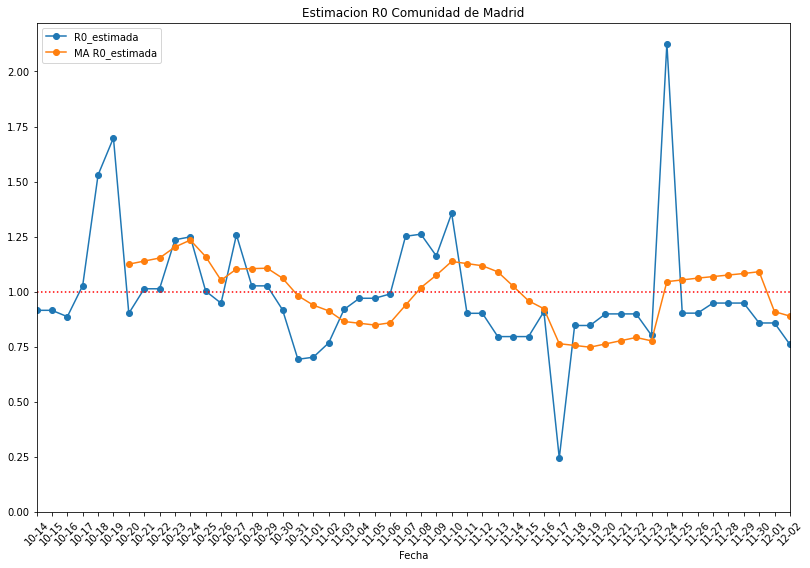

,R0_estimada,MA R0_estimada
Fecha,,
2020-12-02 00:00:00,0.761,0.890
2020-12-01 00:00:00,0.858,0.910
2020-11-30 00:00:00,0.858,1.091
2020-11-29 00:00:00,0.949,1.083
2020-11-28 00:00:00,0.949,1.076
2020-11-27 00:00:00,0.949,1.069
2020-11-26 00:00:00,0.903,1.062
2020-11-25 00:00:00,0.903,1.054
2020-11-24 00:00:00,2.126,1.046


In [8]:
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

df = df_master

def calcular_estimaciones_R0(df):
    def calcular_R0_dia(dia,df):
        dia_semana_anterior = dia - timedelta(days=7)
        return dia,df.loc[dia:dia - timedelta(days=6)]['FALLECIDOS TOTALES hoy'].sum() / df.loc[dia- timedelta(days=7):dia - timedelta(days=13)]['FALLECIDOS TOTALES hoy'].sum() 

    VENTANA_MEDIA_MOVIL=7
    
    df_R0_estimada = pd.DataFrame([calcular_R0_dia(dia,df) for dia in df.index[0:50]],columns=['Fecha','R0_estimada'])
    
    df_R0_estimada = df_R0_estimada.sort_values(by=['Fecha'], ascending=True)
    df_R0_estimada['MA R0_estimada'] = df_R0_estimada['R0_estimada'].rolling(window=VENTANA_MEDIA_MOVIL).mean()
    df_R0_estimada = df_R0_estimada.sort_values(by=['Fecha'], ascending=False)
    df_R0_estimada.set_index('Fecha', inplace=True, drop=True)
    return df_R0_estimada

df= calcular_estimaciones_R0(df_master)
#df=df[['R0_estimada']]
df

chart_df=df[df.columns[-3:]]
chart_df.plot(legend=True,figsize=(13.5,9), marker='o')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=45)

ax = plt.gca()
ax.axhline(1, color='r',linestyle =  ':' ) 


ax.set_title("Estimacion R0 Comunidad de Madrid")
ax.set_ylim(ymin=0)

plt.show()

df.style.format ({ c : "{:20,.3f}" for c in df.columns }).background_gradient(cmap='Wistia', )



In [9]:
R0_estimada * 1.2

0.913170731707317

In [10]:
HTML("<h2>Gráfico muertes diarias en Madrid, según Comunidad de Madrid </h2>")    


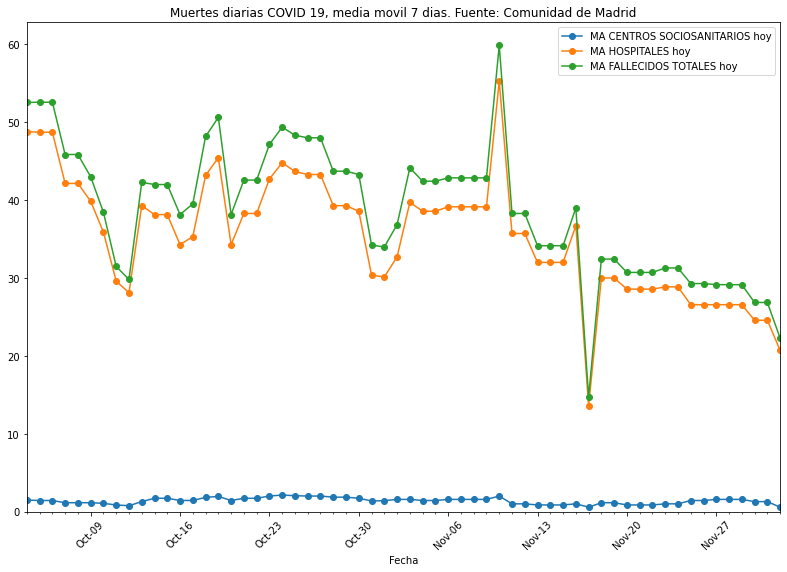

In [11]:
import pandas as pd
import io
import matplotlib.dates as mdates
from matplotlib import pyplot as plt

df = df_master
chart_df=df[df.columns[-3:]].head(60)
chart_df.plot(legend=True,figsize=(13.5,9), marker='o')


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.xticks(rotation=45)

ax = plt.gca()
plt.setp(ax.get_xminorticklabels(), visible=False)

ax.set_title("Muertes diarias COVID 19, media movil "+str(VENTANA_MEDIA_MOVIL)+" dias. Fuente: Comunidad de Madrid")
ax.set_ylim(ymin=0)

plt.show()



In [12]:
 from IPython.display import display, HTML
HTML("<h2>Comparamos los datos de hoy, de hace una semana y de un mes </h2>")    

In [13]:


from matplotlib import colors

def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

df = df_master

df.style.format ({ c : "{:20,.0f}" for c in df.columns }).background_gradient(cmap='Wistia', subset= df.columns[-3:] )



,CENTROS SOCIOSANITARIOS,DOMICILIOS,FALLECIDOS TOTALES,HOSPITALES,OTROS LUGARES,PACIENTES UCI ACUMULADOS,PACIENTES UCI DIA,HOSPITALES hoy,CENTROS SOCIOSANITARIOS hoy,FALLECIDOS TOTALES hoy,MA CENTROS SOCIOSANITARIOS hoy,MA HOSPITALES hoy,MA FALLECIDOS TOTALES hoy
Fecha,,,,,,,,,,,,,
2020-12-02 00:00:00,"4,954","1,146","18,957","12,827",30,"6,555",318,72,2,78,1,21,22
2020-12-01 00:00:00,"4,952","1,142","18,879","12,755",30,"6,540",340,0,0,0,1,25,27
2020-11-30 00:00:00,"4,952","1,142","18,879","12,755",30,"6,517",343,21,0,22,1,25,27
2020-11-29 00:00:00,"4,952","1,141","18,857","12,734",30,"6,507",341,0,0,0,2,27,29
2020-11-28 00:00:00,"4,952","1,141","18,857","12,734",30,"6,496",339,0,0,0,2,27,29
2020-11-27 00:00:00,"4,952","1,141","18,857","12,734",30,"6,478",349,52,2,56,2,27,29
2020-11-26 00:00:00,"4,950","1,139","18,801","12,682",30,"6,453",343,0,0,0,1,27,29
2020-11-25 00:00:00,"4,950","1,139","18,801","12,682",30,"6,430",351,99,7,110,1,27,29
2020-11-24 00:00:00,"4,943","1,135","18,691","12,583",30,"6,411",368,0,0,0,1,29,31


In [14]:
df = df_master
pd.concat([df.head(1).tail(1) , df.head(8).tail(1) , df.head(30).tail(1)]).astype(int)[['MA HOSPITALES hoy','MA CENTROS SOCIOSANITARIOS hoy','MA FALLECIDOS TOTALES hoy']].style.format ({ c : "{:20,.0f}" for c in df.columns }).background_gradient(cmap='Wistia', subset= df.columns[-3:] )

,MA HOSPITALES hoy,MA CENTROS SOCIOSANITARIOS hoy,MA FALLECIDOS TOTALES hoy
Fecha,,,
2020-12-02 00:00:00,20,0,22
2020-11-25 00:00:00,26,1,29
2020-11-03 00:00:00,39,1,44


In [15]:
from IPython.display import display, HTML
HTML("<h2>Muertes medias diarias, últimos 7 días, con datos</h2>")

In [16]:

from datetime import date

df = df_master
inicio_crisis = df.head(7).index[6]
df=df.head(7)
dia_mas_reciente = df.index[0]
dias_transcurridos_inicio_crisis = dia_mas_reciente - inicio_crisis
df = pd.DataFrame((df.head(1).max(axis=0) - df.tail(1).max(axis=0) ) /  dias_transcurridos_inicio_crisis.days  ).T[['HOSPITALES','DOMICILIOS','CENTROS SOCIOSANITARIOS','OTROS LUGARES','FALLECIDOS TOTALES']]
df.style.format ({ c : "{:20,.0f}" for c in df.columns }).background_gradient(cmap='Wistia'  )
  


,HOSPITALES,DOMICILIOS,CENTROS SOCIOSANITARIOS,OTROS LUGARES,FALLECIDOS TOTALES
0,24,1,1,0,26


In [17]:
HTML("<h2>Muertes medias diarias desde que la comunidad de Madrid publica datos</h2>")

In [18]:
# Calculamos los incrementos medios, desde que tenemos fechas
df = df_master
df = pd.DataFrame((df.head(1).max(axis=0) - df.tail(1).max(axis=0) ) / df.shape[0] ).T[['HOSPITALES','DOMICILIOS','CENTROS SOCIOSANITARIOS','OTROS LUGARES','FALLECIDOS TOTALES']]
df.style.format ({ c : "{:20,.0f}" for c in df.columns }).background_gradient(cmap='Wistia'  )

,HOSPITALES,DOMICILIOS,CENTROS SOCIOSANITARIOS,OTROS LUGARES,FALLECIDOS TOTALES
0,25,2,5,0,32


In [19]:
from tabula import read_pdf
from IPython.display import display, HTML
import os 
import pandas as pd
import glob 
import re 
from tqdm.notebook import tqdm
import warnings
import os.path
fecha="201005"
import os
file_path = '../data/'+fecha+'_cam_covid19.pdf'
if not os.path.isfile(file_path):
    file_path = '../data/'+fecha+'cam_covid19.pdf'
#print("Analizando:" + file_path)


In [20]:
df_pdf =  read_pdf(file_path,area=(300, 100, 800, 400) , pages='1')
df_pdf

Got stderr: dic 03, 2020 4:53:07 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
ADVERTENCIA: Using fallback font 'LiberationSans' for 'Arial,Bold'



[                                           Unnamed: 0         256.667
 0                                                 NaN    (acumulados)
 1                                          Pacie ntes    Pacientes en
 2                                      Hospitalizados             UCI
 3                                               3.047             501
 4                                      (ingresados en  (ingresados en
 5                                             el dia)         el día)
 6                                              59.757           5.234
 7                                        (acumulados)             NaN
 8                                                 NaN    (acumulados)
 9                                                 NaN             NaN
 10  e: Dirección General de Salud Pública, Servici...             NaN]

In [21]:
for x,y in enumerate(df_pdf):
    print(x,"::",y)
    
pd.DataFrame(df_pdf)    

0 ::                                            Unnamed: 0         256.667
0                                                 NaN    (acumulados)
1                                          Pacie ntes    Pacientes en
2                                      Hospitalizados             UCI
3                                               3.047             501
4                                      (ingresados en  (ingresados en
5                                             el dia)         el día)
6                                              59.757           5.234
7                                        (acumulados)             NaN
8                                                 NaN    (acumulados)
9                                                 NaN             NaN
10  e: Dirección General de Salud Pública, Servici...             NaN


,0
0,Unn...


In [22]:
type(df_pdf)

list

In [23]:
type(df_pdf[0])

pandas.core.frame.DataFrame

In [24]:
total

,CENTROS SOCIOSANITARIOS,DOMICILIOS,FALLECIDOS TOTALES,HOSPITALES,OTROS LUGARES,PACIENTES UCI ACUMULADOS,PACIENTES UCI DIA,HOSPITALES hoy,CENTROS SOCIOSANITARIOS hoy,FALLECIDOS TOTALES hoy
Fecha,,,,,,,,,,
2020-12-02,4954,1146,18957,12827,30,6555,318,72.0,2.0,78.0
2020-12-01,4952,1142,18879,12755,30,6540,340,0.0,0.0,0.0
2020-11-30,4952,1142,18879,12755,30,6517,343,21.0,0.0,22.0
2020-11-29,4952,1141,18857,12734,30,6507,341,0.0,0.0,0.0
2020-11-28,4952,1141,18857,12734,30,6496,339,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-04-26,4236,798,12855,7800,21,0,0,167.0,66.0,243.0
2020-04-25,4170,788,12612,7633,21,0,0,245.0,102.0,360.0
2020-04-24,4068,775,12252,7388,21,0,0,117.0,72.0,196.0


In [25]:


get_daily_date_new_format("201005")

Got stderr: dic 03, 2020 4:53:08 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
ADVERTENCIA: Using fallback font 'LiberationSans' for 'Arial,Bold'

Got stderr: dic 03, 2020 4:53:10 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
ADVERTENCIA: Using fallback font 'LiberationSans' for 'Arial,Bold'



,PACIENTES UCI DIA,PACIENTES UCI ACUMULADOS,HOSPITALES,DOMICILIOS,CENTROS SOCIOSANITARIOS,OTROS LUGARES,FALLECIDOS TOTALES
Fecha,,,,,,,
2020-10-05,501,5234,10803,1035,4874,30,16742


In [26]:
total

,CENTROS SOCIOSANITARIOS,DOMICILIOS,FALLECIDOS TOTALES,HOSPITALES,OTROS LUGARES,PACIENTES UCI ACUMULADOS,PACIENTES UCI DIA,HOSPITALES hoy,CENTROS SOCIOSANITARIOS hoy,FALLECIDOS TOTALES hoy
Fecha,,,,,,,,,,
2020-12-02,4954,1146,18957,12827,30,6555,318,72.0,2.0,78.0
2020-12-01,4952,1142,18879,12755,30,6540,340,0.0,0.0,0.0
2020-11-30,4952,1142,18879,12755,30,6517,343,21.0,0.0,22.0
2020-11-29,4952,1141,18857,12734,30,6507,341,0.0,0.0,0.0
2020-11-28,4952,1141,18857,12734,30,6496,339,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-04-26,4236,798,12855,7800,21,0,0,167.0,66.0,243.0
2020-04-25,4170,788,12612,7633,21,0,0,245.0,102.0,360.0
2020-04-24,4068,775,12252,7388,21,0,0,117.0,72.0,196.0
